### Summarising Calibration Results

In [48]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import norm, gaussian_kde
from matplotlib.lines import Line2D
import pyabc
from network_input_builder import *
path = "~/Documents/Documents - Nuff-Malham/GitHub/transition_abm/"


In [53]:

sns.set_style("whitegrid")

prefix = "cos_calib/"
which_params = 'single_node'

if which_params == "onet":
    nw_label = "ONET"
elif which_params == "full_omn":
    nw_label = "Occupational Mobility Network"
elif which_params == "omn_soc_minor":
    nw_label = "OMN - SOC Minor"
elif which_params == "single_node":
    nw_label = "Single Node Network"

# list of model identifiers (your db_path values)
models = [
    "nonbehav",
    "otj_nonbehav",
    "otj_disc_no_rw",
    "otj_cyclical_e_disc_no_rw",
    "otj_disc",
    "otj_cyclical_e_disc",
    "otj_disc_strict_rw",
    "otj_cyclical_e_disc_strict_rw"
]

name_map = {
        "nonbehav": "Non-behavioural",
        "otj_nonbehav": "Non-behavioural w. OTJ",
        "otj_cyclical_e_disc": "Behavioural w. Cyc. OTJ w. RW",
        "otj_disc": "Behavioural w.o. Cyc. OTJ w. RW",
        "otj_disc_strict_rw": "Behavioural w.o. Cyc. OTJ w. Strict RW",
        "otj_cyclical_e_disc_strict_rw": "Behavioural w. Cyc. OTJ w. Strict RW",
        "otj_cyclical_e_disc_no_rw": "Behavioural w. Cyc. OTJ w.o RW",
        "otj_disc_no_rw": "Behavioural w.o. Cyc. OTJ w.o RW"
    }



In [56]:
# replace this function with your actual loader that returns (df, w)
def load_model_distribution(db_path):
    """
    Return (df, w) for a model. Replace this with your code that
    reads history and calls history.get_distribution(t=history.max_t).
    df: pandas.DataFrame with columns 'd_u', 'gamma_u', optional 'theta'
    w: 1D numpy array of weights aligned with df.index
    """
    # --- PLACEHOLDER: replace with your actual loader ---
    history = pyabc.History("sqlite:///" + f"output/{prefix}{which_params}/{name}.db")
    print(f"output/{prefix}{which_params}/{name}.db")
    df, w = history.get_distribution(t=history.max_t)
    if len(df) == 0:
        print(f'{name} empty')

    return df, w

# safe kde wrapper: uses seaborn weights when available, else resamples
def plot_kde_on_ax(ax, x, y=None, weights=None, label=None, color=None, bw_adjust=1.0, fill=False, levels=6, alpha = 1):
    """
    If y is None -> 1d kde; if y provided -> 2d kde contour.
    Tries to use sns.kdeplot(weights=...). If seaborn does not support weights for your version,
    falls back to weighted resampling.
    """
    use_seaborn_weights = True
    try:
        # try a direct call - will raise if weights unsupported
        if y is None:
            sns.kdeplot(x=x, ax=ax, weights=weights, label=label, color=color, bw_adjust=bw_adjust, fill=fill, alpha = alpha)
        else:
            sns.kdeplot(x=x, y=y, ax=ax, weights=weights, color=color, levels=levels, bw_adjust=bw_adjust, fill=fill, alpha = alpha)
        return
    except TypeError:
        use_seaborn_weights = False

    # fallback: weighted resample
    n_resample = min(4000, max(500, int(len(x) * 0.1)))  # sample up to 4000 points
    if weights is None:
        idx = np.random.choice(len(x), size=n_resample, replace=True)
    else:
        p = np.array(weights, dtype=float)
        p = p / p.sum()
        idx = np.random.choice(len(x), size=n_resample, replace=True, p=p)

    xs = np.asarray(x)[idx]
    if y is None:
        sns.kdeplot(x=xs, ax=ax, label=label, color=color, bw_adjust=bw_adjust, fill=fill, alpha = alpha)
    else:
        ys = np.asarray(y)[idx]
        sns.kdeplot(x=xs, y=ys, ax=ax, label=label, color=color, levels=levels, bw_adjust=bw_adjust, fill=fill, alpha = alpha)


# Collect all model samples
samples = {}
for name in models:
    try:
        df, w = load_model_distribution(name)
    except NotImplementedError:
        # ####### TEMP TEST DATA (remove when you plug in real loader) #######
        # Create a toy df to let the script run for demo purposes.
        rng = np.random.RandomState(abs(hash(name)) % 2**32)
        n = 2000
        # d_u and gamma_u vary by model label
        base = {"nonbehav": 0.2, "otj_nonbehav": 0.25, "otj_disc": 0.3,
                "otj_disc_no_rw": 0.28, "otj_cyclical_e_disc": 0.45, "otj_cyclical_e_disc_no_rw": 0.42}
        theta_present = name in ("otj_cyclical_e_disc", "otj_cyclical_e_disc_no_rw")
        df = pd.DataFrame({
            "d_u": rng.normal(loc=base[name], scale=0.03, size=n),
            "gamma_u": rng.normal(loc=base[name]*1.5, scale=0.05, size=n),
        })
        if theta_present:
            df["theta"] = rng.normal(loc=0.35, scale=0.06, size=n)
        w = np.ones(len(df)) / len(df)
        # ###################################################################
    samples[name] = {"df": df, "w": np.asarray(w)}

# palette & colors
palette = sns.color_palette("Paired", 12)

blues      = palette[0:2]
greens     = palette[2:4]
reds       = palette[4:6]
oranges    = palette[6:8]
purples    = palette[8:10]
yellows    = palette[10:12]

my_colors = blues + oranges + purples + greens
colors = dict(zip(models, my_colors))

# compute global axis limits for nicer consistent plotting
def global_limits(col, pad_frac=0.05):
    vals = []
    for m in samples:
        ser = samples[m]["df"].get(col)
        if ser is None: continue
        vals.append(ser.values)
    if len(vals) == 0:
        return None
    arr = np.concatenate(vals)
    lo, hi = np.nanpercentile(arr, [0.5, 99.5])
    rng = hi - lo
    return (max(0, lo - pad_frac*rng), hi + pad_frac*rng)

du_lim = global_limits("d_u")
gu_lim = global_limits("gamma_u")
theta_lim = global_limits("theta")

limit_buffer = 0
du_min, du_max = global_limits("d_u")
gu_min, gu_max = global_limits("gamma_u")
theta_min, theta_max = global_limits("theta")

du_min -= limit_buffer
du_max += limit_buffer
gu_min -= limit_buffer
gu_max += limit_buffer
theta_min -= limit_buffer
theta_max += limit_buffer

out_dir = f'output/{prefix}{which_params}/figures/calib_figures/'
os.makedirs(out_dir, exist_ok=True)



output/cos_calib/single_node/nonbehav.db
output/cos_calib/single_node/otj_nonbehav.db
output/cos_calib/single_node/otj_disc_no_rw.db
output/cos_calib/single_node/otj_cyclical_e_disc_no_rw.db
output/cos_calib/single_node/otj_disc.db
output/cos_calib/single_node/otj_cyclical_e_disc.db
output/cos_calib/single_node/otj_disc_strict_rw.db
output/cos_calib/single_node/otj_cyclical_e_disc_strict_rw.db


nonbehav
otj_nonbehav
otj_disc_no_rw
otj_cyclical_e_disc_no_rw
otj_disc
otj_cyclical_e_disc
otj_disc_strict_rw
otj_cyclical_e_disc_strict_rw


/var/folders/8b/bf75_lhn2ks3ff8jvrhctcvc0000gr/T/ipykernel_22475/3725705760.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.legend(loc="lower center", ncol = 3)


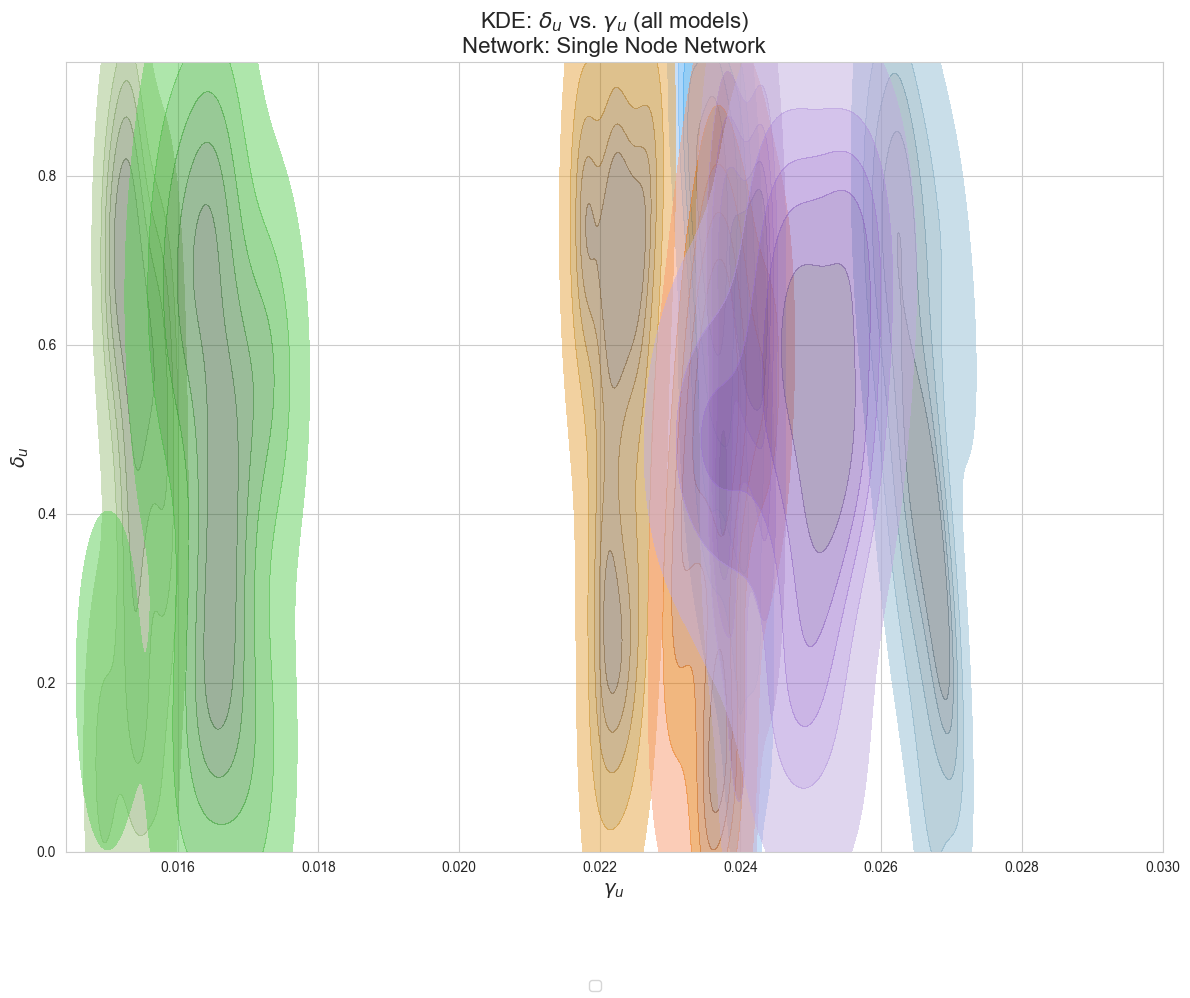

In [57]:
# ------------------- 1) Joint: d_u vs gamma_u (all models) -------------------
fig, ax = plt.subplots(figsize=(12,10))
for name, meta in samples.items():
    df = meta["df"]
    w = meta["w"]
    print(name)
    if "d_u" not in df.columns or "gamma_u" not in df.columns:
        continue
    plot_kde_on_ax(ax, df["d_u"], df["gamma_u"],  weights=w, label=name_map.get(name, name), color=colors[name], levels=6, fill = True, alpha = 0.5)
    # weighted mean marker
    my = np.average(df["gamma_u"].values, weights=w)
    mx = np.average(df["d_u"].values, weights=w)
    #ax.scatter(mx, my, s=50, marker="o", linewidth=0.8, color=colors[name], label=name_map.get(name, name))


ax.set_ylabel(r"$\delta_u$", fontsize = 14)
ax.set_xlabel(r"$\gamma_u$", fontsize = 14)
if du_lim: ax.set_xlim(max(0, du_min), max(0.03, du_max))
if gu_lim: ax.set_ylim(max(0, gu_min), gu_max)
ax.set_title(f"KDE: $\\delta_u$ vs. $\\gamma_u$ (all models)\nNetwork: {nw_label}", fontsize = 16)
fig.legend(loc="lower center", ncol = 3)
plt.tight_layout(rect=[0, 0.08, 1, 1])  # leave space at bottom for legend
#plt.tight_layout()
plt.savefig(os.path.join(out_dir, "all_models_du_vs_gu.png"), dpi=300)
plt.show()
plt.close(fig)



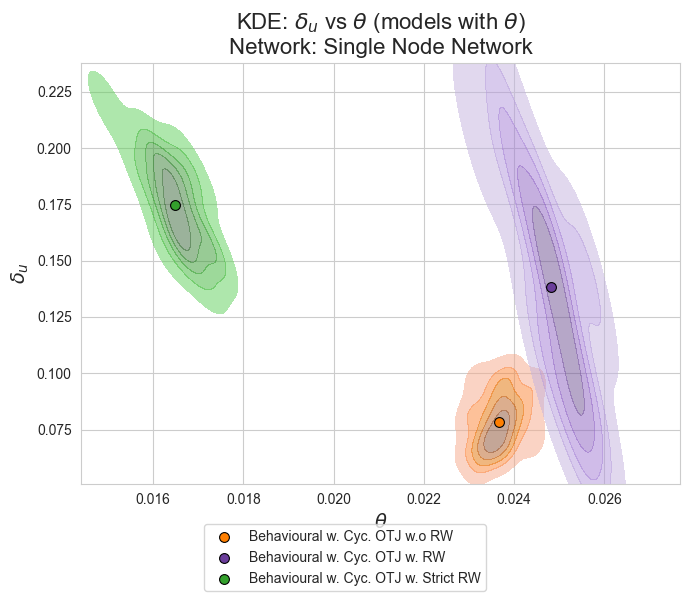

In [58]:
# ------------------- 2) Joint: d_u vs theta (only models with theta) -------------------
fig, ax = plt.subplots(figsize=(7,6))
any_theta = False
for name, meta in samples.items():
    df = meta["df"]
    w = meta["w"]
    if "theta" not in df.columns:
        continue
    any_theta = True
    plot_kde_on_ax(ax, df["d_u"], df["theta"], weights=w,  color=colors[name], levels=6, fill =True, alpha = 0.5)
    ax.scatter(np.average(df["d_u"].values, weights=w), np.average(df["theta"].values, weights=w), 
               color=colors[name], s=50, marker="o", edgecolor="k", linewidth=0.8, label=name_map.get(name, name))

if any_theta:
    ax.set_ylabel(r"$\delta_u$", fontsize = 14)
    ax.set_xlabel(r"$\theta$", fontsize = 14)
    if du_lim: ax.set_xlim(du_lim)
    if theta_lim: ax.set_ylim(theta_lim)
    ax.set_title(f"KDE: $\\delta_u$ vs $\\theta$ (models with $\\theta$)\nNetwork: {nw_label}", fontsize = 16)
    #ax.legend(bbox_to_anchor=(0.5,-1), loc="lower center")
    fig.legend(loc="lower center", ncol = 1)
    plt.tight_layout(rect=[0, 0.08, 1, 1])  # leave space at bottom for legend
    plt.savefig(os.path.join(out_dir, "all_models_du_vs_theta.png"), dpi=300)
    plt.show()
    plt.close(fig)
else:
    print("No models had theta -> skipping d_u vs theta plot.")



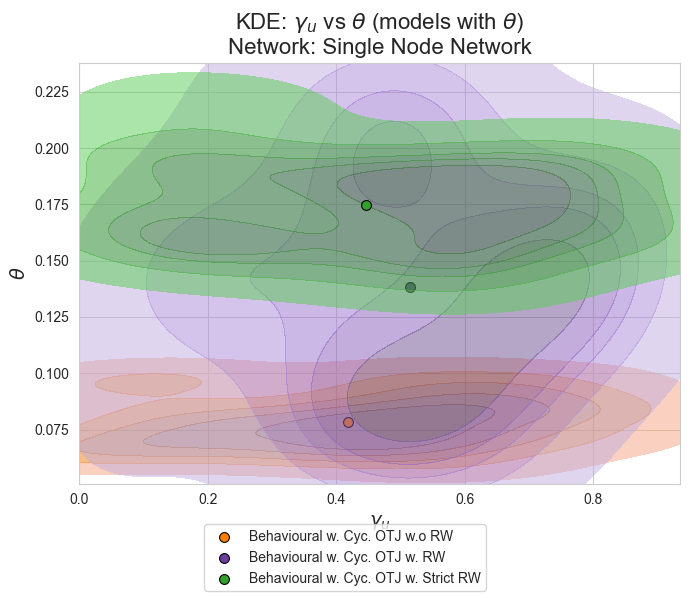

In [59]:

# ------------------- 3) Joint: gamma_u vs theta (only models with theta) -------------------
fig, ax = plt.subplots(figsize=(7,6))
any_theta = False
for name, meta in samples.items():
    df = meta["df"]
    w = meta["w"]
    if "theta" not in df.columns:
        continue
    any_theta = True
    plot_kde_on_ax(ax, df["gamma_u"], df["theta"], weights=w, color=colors[name], levels=6, fill = True, alpha = 0.5)
    ax.scatter(np.average(df["gamma_u"].values, weights=w), np.average(df["theta"].values, weights=w),label=name_map.get(name, name), 
               color=colors[name], s=50, marker="o", edgecolor="k", linewidth=0.8)

if any_theta:
    ax.set_xlabel(r"$\gamma_u$", fontsize = 14)
    ax.set_ylabel(r"$\theta$", fontsize = 14)
    if gu_lim: ax.set_xlim(gu_lim)
    if theta_lim: ax.set_ylim(theta_lim)
    ax.set_title(f"KDE: $\\gamma_u$ vs $\\theta$ (models with $\\theta$)\nNetwork: {nw_label}", fontsize = 16)
    fig.legend(loc="lower center", ncol = 1)
    plt.tight_layout(rect=[0, 0.08, 1, 1])  # leave space at bottom for legend
    plt.savefig(os.path.join(out_dir, "all_models_gu_vs_theta.png"), dpi=300)
    plt.show()
    plt.close(fig)
else:
    print("No models had theta -> skipping gamma_u vs theta plot.")



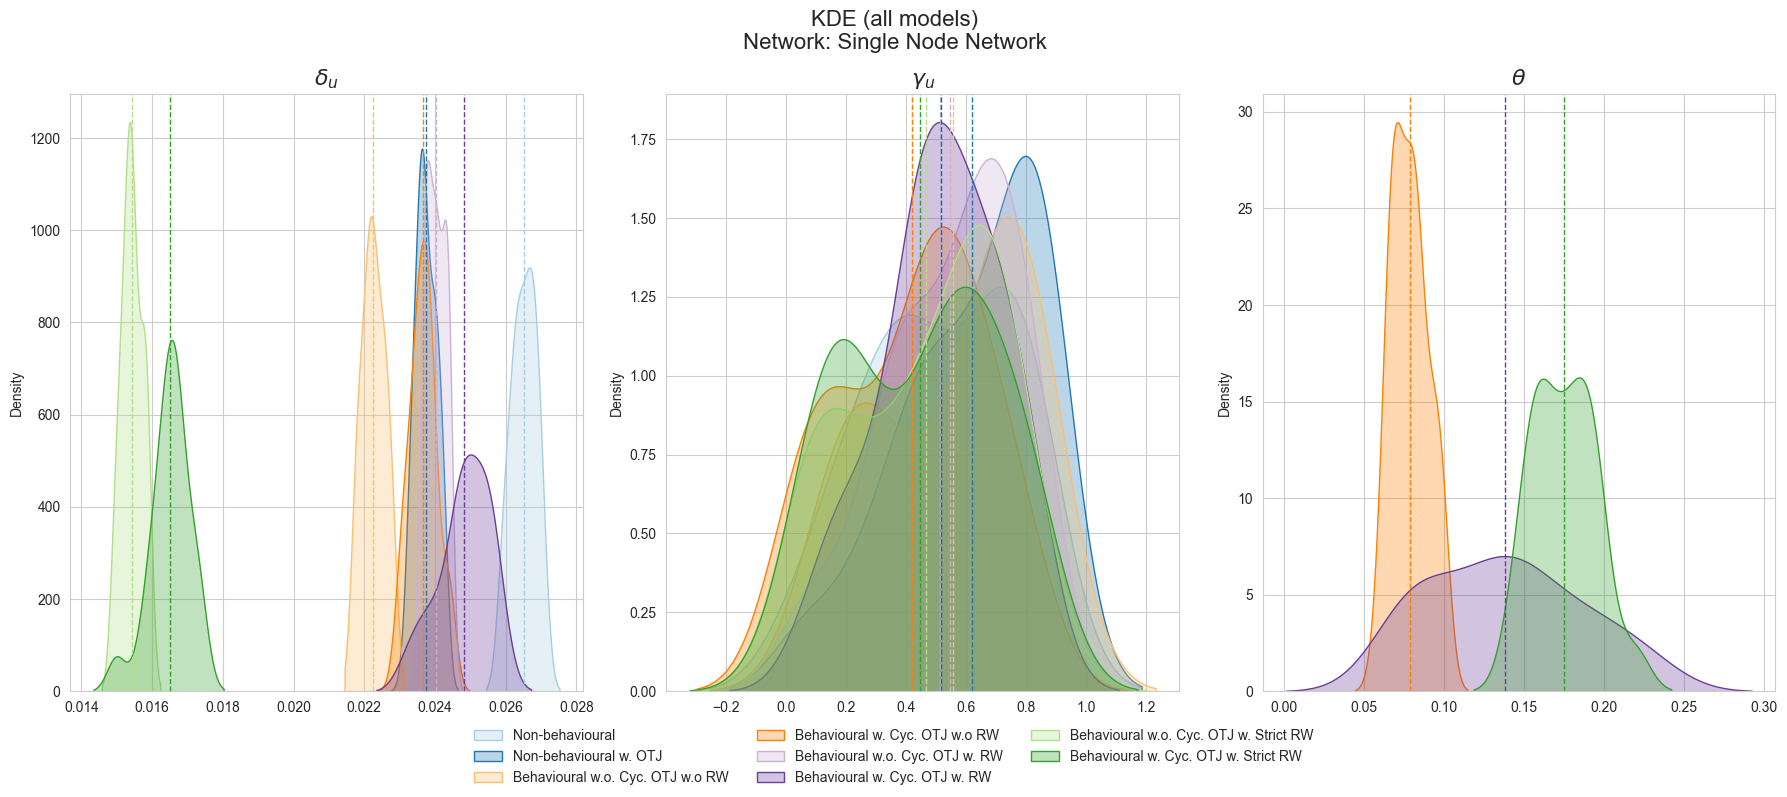

Saved combined plots to output/cos_calib/single_node/figures/calib_figures/


In [60]:
# ------------------- 4) "Diagonal KDE matrix": 1D marginals overlaid -------------------
vars_to_plot = ["d_u", "gamma_u", "theta"]
fig, axes = plt.subplots(1, 3, figsize=(18,8))   # wider subplots

for idx, var in enumerate(vars_to_plot):
    ax = axes[idx]
    for name, meta in samples.items():
        df = meta["df"]
        w = meta["w"]
        if var not in df.columns:
            continue
        plot_kde_on_ax(ax, df[var], weights=w, label=name_map.get(name, name), color=colors[name], fill=True, alpha = 0.3)
        # weighted mean vertical line
        ax.axvline(np.average(df[var].values, weights=w), color=colors[name], linestyle='dashed', linewidth=1)
    if var == "d_u":
        ax.set_title(r"$\delta_u$", fontsize = 16)
    elif var == "gamma_u":
        ax.set_title(r"$\gamma_u$", fontsize = 16)
    elif var == "theta":
        ax.set_title(r"$\theta$", fontsize = 16)
    ax.set_xlabel(None)
    ax.set_xlim()

                     
# Place one combined legend below all plots
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncol=3, fontsize=10, frameon=False)
fig.suptitle(f"KDE (all models)\nNetwork: {nw_label}", fontsize = 16)

plt.tight_layout(rect=[0, 0.08, 1, 1])  # leave space at bottom for legend
plt.savefig(os.path.join(out_dir, "all_models_marginals.png"), dpi=300)
plt.show()
plt.close(fig)

print("Saved combined plots to", out_dir)

IndexError: index 3 is out of bounds for axis 0 with size 3

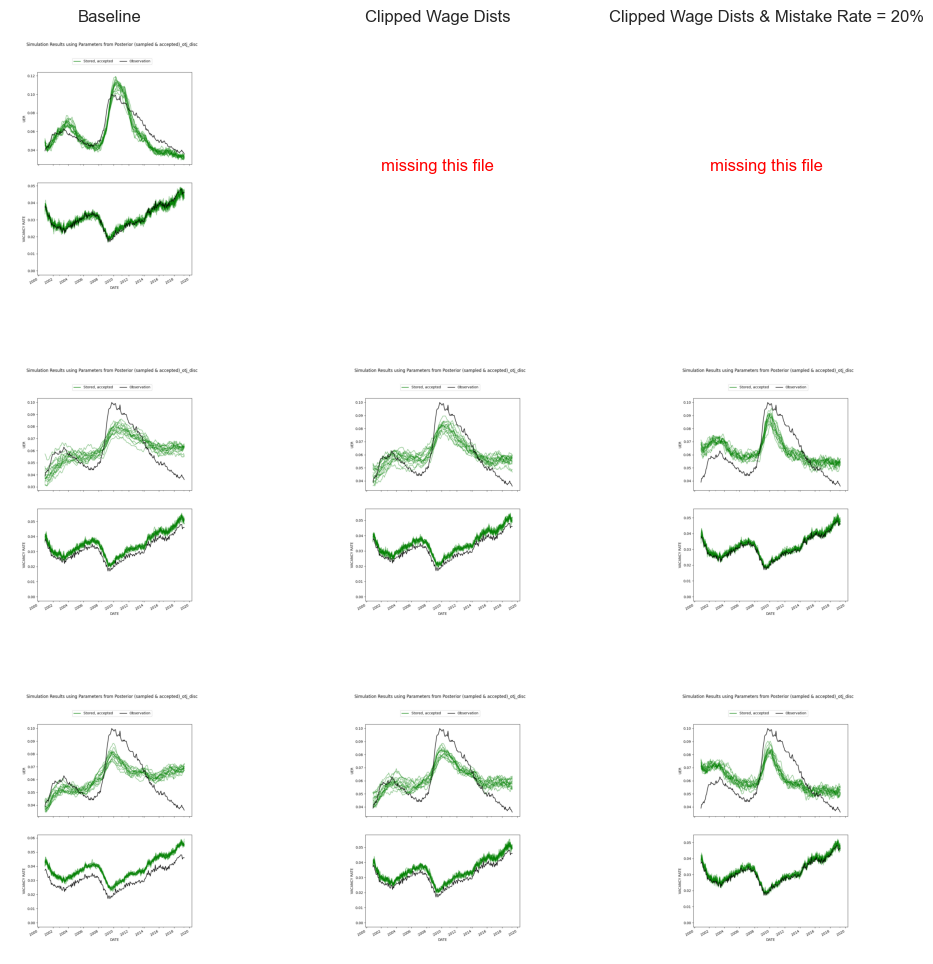

In [61]:
import matplotlib.image as mpimg
folder_names = [
    "single_node",
    "full_omn",
    "onet",
    "onet_wage_asym"
]

image_files = [
    "calibration_otj_disc_sim_results.png",
    "calibration_otj_disc_CLIPPED_W_sim_results.png",
    "calibration_otj_disc_CLIPPED_W_MISRATE_20_sim_results.png"
]

column_labels = [
    "Baseline",
    "Clipped Wage Dists",
    "Clipped Wage Dists & Mistake Rate = 20%"
]

fig, axes = plt.subplots(3, 3, figsize=(12, 12))

for row, folder in enumerate(folder_names):
    for col, img_name in enumerate(image_files):

        ax = axes[row, col]
        if folder == "onet" and img_name == "calibration_otj_disc_sim_results.png":
            temp_folder = "onet_2"
            img_path = f"output/{temp_folder}/{img_name}"
        else:
            img_path = f"output/{folder}/{img_name}"

        # Put folder name on left-hand side (only once per row)
        if col == 0:
            ax.set_ylabel(folder, rotation=90, fontsize=12, labelpad=20, va='center')

        # Put column label on top row only
        if row == 0:
            ax.set_title(column_labels[col], fontsize=12)

        # Load image or placeholder
        if os.path.exists(img_path):
            img = mpimg.imread(img_path)
            ax.imshow(img)
        else:
            ax.text(
                0.5, 0.5,
                "missing this file",
                ha="center", va="center",
                fontsize=12, color="red"
            )

        ax.axis("off")

plt.tight_layout()
plt.show()

output/full_omn/otj_disc.db
output/full_omn/otj_disc_CLIPPED_W.db
output/full_omn/otj_disc_CLIPPED_W_MISRATE_20.db
output/full_omn/otj_disc_no_rw.db
onet_2
output/onet_2/otj_disc.db
output/onet/otj_disc_CLIPPED_W.db
output/onet/otj_disc_CLIPPED_W_MISRATE_20.db
onet_2
output/onet_2/otj_disc_no_rw.db
output/onet_wage_asym/otj_disc.db
output/onet_wage_asym/otj_disc_CLIPPED_W.db
output/onet_wage_asym/otj_disc_CLIPPED_W_MISRATE_20.db
output/onet_wage_asym/otj_disc_no_rw.db


<>:90: SyntaxWarning: invalid escape sequence '\g'
<>:90: SyntaxWarning: invalid escape sequence '\g'
/var/folders/8b/bf75_lhn2ks3ff8jvrhctcvc0000gr/T/ipykernel_22475/3887674732.py:90: SyntaxWarning: invalid escape sequence '\g'
  plt.suptitle(f"Kernel Density Plot: $\gamma_u$ (Behav. w. Res. Wages)", fontsize = 16)


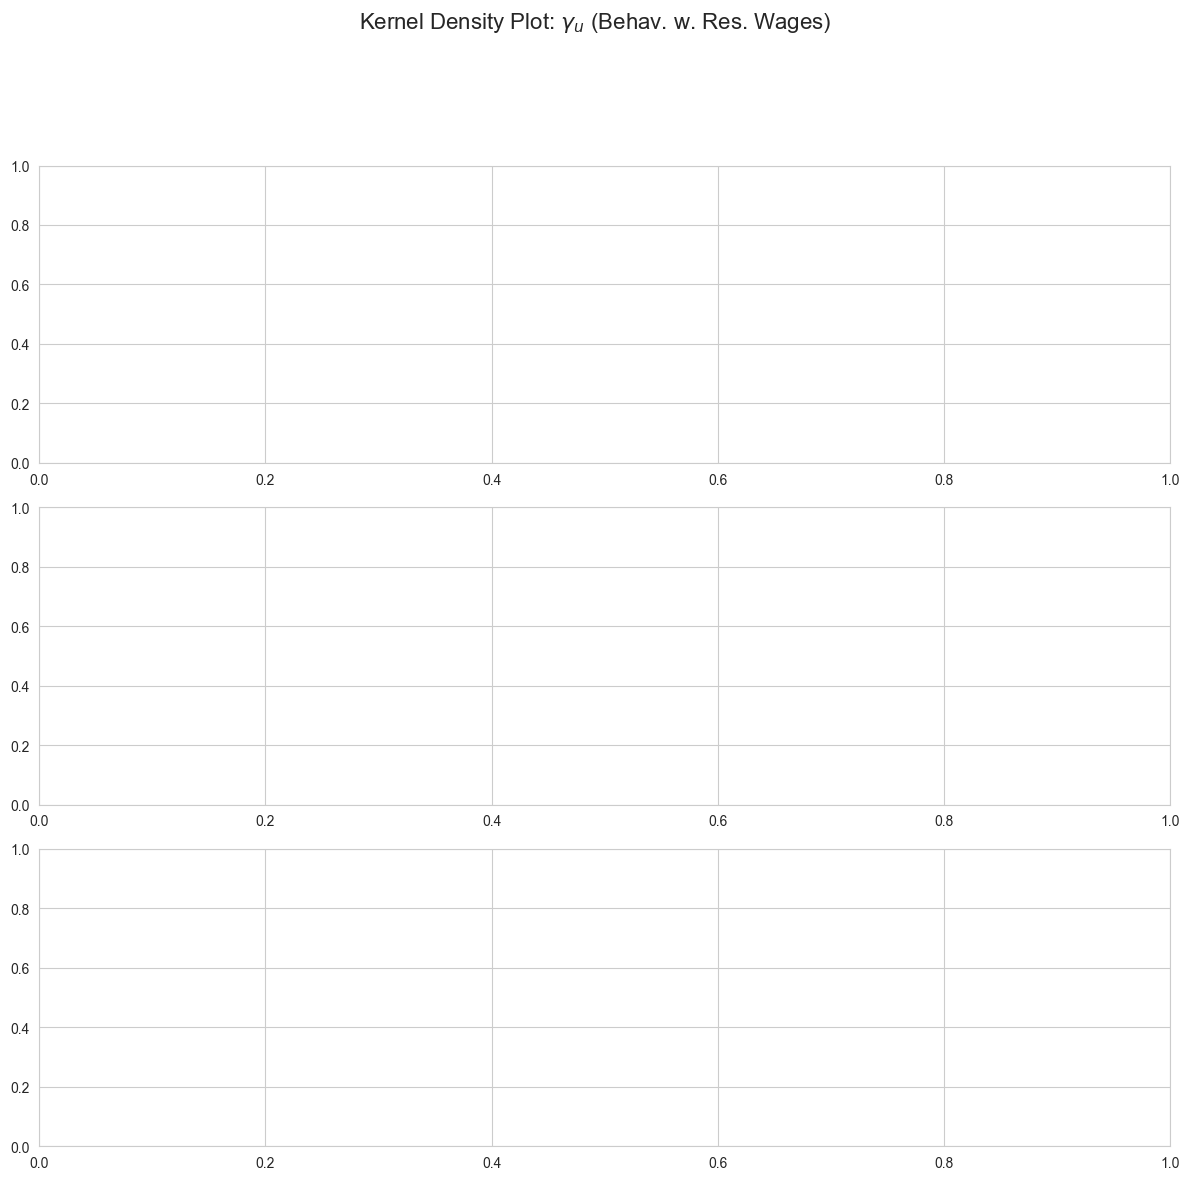

In [ ]:
new_models = ['otj_disc',
              'otj_disc_CLIPPED_W',
              'otj_disc_CLIPPED_W_MISRATE_20',
              'otj_disc_no_rw']

# replace this function with your actual loader that returns (df, w)
def load_model_distribution(db_path, folder):
    """
    Return (df, w) for a model. Replace this with your code that
    reads history and calls history.get_distribution(t=history.max_t).
    df: pandas.DataFrame with columns 'd_u', 'gamma_u', optional 'theta'
    w: 1D numpy array of weights aligned with df.index
    """
    # --- PLACEHOLDER: replace with your actual loader ---
    history = pyabc.History("sqlite:///" + f"output/{folder}/{name}.db")
    print(f"output/{folder}/{name}.db")
    df, w = history.get_distribution(t=history.max_t)
    if len(df) == 0:
        print(f'{name} empty')

    return df, w


folder_names = [
    "full_omn",
    "onet",
    "onet_wage_asym"
]

folder_labels = ['OMN', "ONET", "ONET w. Add. Edges"]

nw_labels = dict(zip(folder_names, folder_labels))

column_labels = [
    "Baseline",
    "Clipped Wage Dists",
    "Clipped Wage Dists & Mistake Rate = 20%",
    "w.o Res. Wage"
]

colors = ["green", "orange", "blue", "grey"]
colors = dict(zip(new_models, colors))

labels = dict(zip(new_models, column_labels))

fig, axes = plt.subplots(3, 1, figsize=(12, 12))

for row, folder in enumerate(folder_names):
    # Collect all model samples
    samples = {}
    for name in new_models:
        if folder == "onet" and name in ['otj_disc_no_rw', 'otj_disc']:
            temp_folder = "onet_2"
            print(temp_folder)
            df, w = load_model_distribution(name, temp_folder)
            samples[name] = {"df": df, "w": np.asarray(w)}
        else:
            df, w = load_model_distribution(name, folder)
            samples[name] = {"df": df, "w": np.asarray(w)}
    

    ax = axes[row]

    for name, meta in samples.items():
        df = meta["df"]
        w = meta["w"]
        if var not in df.columns:
            continue
        sns.kdeplot(ax = ax, x = df['gamma_u'], weights=w, color = colors[name], label = labels[name], fill=True)
        # weighted mean vertical line
        ax.axvline(np.average(df[var].values, weights=w), linestyle='dashed', linewidth=1, color = colors[name])
        ax.set_title(f"Network: {nw_labels[folder]}", fontsize = 14)
        ax.set_xlabel(None)
        ax.set_xlim(0,0.7)

                        
# Get legend entries from the first axis
handles, legend_labels = axes[0].get_legend_handles_labels()

# Place legend below suptitle, above first subplot
fig.legend(
    handles,
    legend_labels,
    loc="upper center",
    bbox_to_anchor=(0.5, 0.96),   # y=0.94 is between suptitle and top subplot
    ncol=1,
    fontsize=12,
    frameon=False
)
plt.suptitle(f"Kernel Density Plot: $\gamma_u$ (Behav. w. Res. Wages)", fontsize = 16)

plt.tight_layout(rect=[0, 0, 1, 0.90])
plt.show()



In [ ]:
#pyabc.History("sqlite:///" + f"output/onet_2/otj_disc_no_rw.db").history.get_distribution(t=history.max_t)
    #df, w = history.get_distribution(t=history.max_t)